# Digital Earth Australia Intertidal workflow

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
pip install -r requirements.in --quiet

### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from ipyleaflet import basemaps, basemap_to_tiles

import datacube
import odc.geo.xr
from odc.geo.geom import Geometry
from odc.ui import select_on_a_map

from intertidal.utils import (
    round_date_strings,
    intertidal_hillshade,
)
from intertidal.tide_modelling import pixel_tides_ensemble
from intertidal.io import load_data, load_topobathy, load_aclum, prepare_for_export
from intertidal.elevation import elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset

from dea_tools.dask import create_local_dask_cluster

## Setup


### Set analysis parameters

In [3]:
# Intertidal Elevation variables
start_date = "2019"  # Start date for analysis
end_date = "2019"  # End date for analysis
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = True  # Filter to remove poorly georeferenced scenes?
tide_model = "ensemble"  # Tide model to use in analysis
# tide_model_dir = "/var/share/tide_models"  # Directory containing tide model files
# tide_model = ["FES2014", "FES2012", "TPXO9-atlas-v5"]
tide_model_dir = "/gdata1/data/tide_models_clipped"

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

#### Set study area

##### Option 1: load study area from 32 km tile GridSpec

In [ ]:
# # Set study area (e.g. tile ID in form "x094y145")
# study_area = "x094y145"
# geom = None  # Use GridSpec to load study area, not a custom geom

##### Option 2: load study area from vector file

In [ ]:
# # Set study area to load from file
# study_area = "pointstuart"

# # Read file, select study area and convert to geom
# studyarea_gdf = gpd.read_file(
#     "data/raw/intertidal_development_polygons.geojson"
# ).set_index("id")
# geom = Geometry(studyarea_gdf.loc[study_area].geometry, crs=studyarea_gdf.crs)
# geom

##### Option 3: load study area using interactive map

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

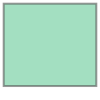

In [4]:
# Set study area name for outputs
study_area = "testing"

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
geom

## Intertidal workflow

### Load data

In [5]:
%%time

# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds, _, _ = load_data(
    dc=dc,
    study_area=study_area,
    geom=geom,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    include_s2=True,
    include_ls=True,
    filter_gqa=filter_gqa,
    max_cloudcover=90,
    skip_broken_datasets=True,
)

print(satellite_ds)

# Load data
satellite_ds.load()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39865,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:37377,Total threads: 15
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/36607/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:41613,


<xarray.Dataset>
Dimensions:      (time: 114, y: 276, x: 318)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-07T01:16:28.775870 ... 2019-12...
  * y            (y) float64 -1.286e+06 -1.286e+06 ... -1.288e+06 -1.288e+06
  * x            (x) float64 -1.43e+04 -1.428e+04 ... -1.114e+04 -1.112e+04
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 dask.array<chunksize=(1, 276, 318), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: user 3.66 s, sys: 460 ms, total: 4.12 s
Wall time: 31 s


<xarray.Dataset>
Dimensions:      (time: 114, y: 276, x: 318)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-07T01:16:28.775870 ... 2019-12...
  * y            (y) float64 -1.286e+06 -1.286e+06 ... -1.288e+06 -1.288e+06
  * x            (x) float64 -1.43e+04 -1.428e+04 ... -1.114e+04 -1.112e+04
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 0.3623 0.3623 0.3614 ... nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Load optional topobathy mask
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [6]:
# Load data from GA's AusBathyTopo 250m 2023 Grid
topobathy_ds = load_topobathy(
    dc, satellite_ds, product="ga_ausbathytopo250m_2023", resampling="bilinear"
)

### Intertidal elevation
To run without the topobathy DEM mask, comment out `valid_mask=...`.

In [7]:
# Model elevation for each pixel
ds, tide_m = elevation(
    satellite_ds,
    valid_mask=topobathy_ds.height_depth > -15,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

2024-02-28 01:16:34 INFO Processing: Modelling tide heights for each pixel


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:19<00:00,  1.83it/s]


Returning low resolution tide array
Generating ensemble tide model from point inputs


2024-02-28 01:16:57 INFO Processing: Masking nodata and adding tide heights to satellite data array
2024-02-28 01:16:57 INFO Processing: Flattening satellite data array and filtering to intertidal candidate pixels
2024-02-28 01:16:57 INFO Processing: Applying valid data mask to constrain study area
2024-02-28 01:16:58 INFO Processing: Running per-pixel rolling median


Reducing analysed pixels from 87768 to 48534 (55.30%)


  0%|          | 0/105 [00:00<?, ?it/s]

2024-02-28 01:17:18 INFO Processing: Modelling intertidal elevation


Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 20


2024-02-28 01:17:18 INFO Processing: Modelling intertidal uncertainty
2024-02-28 01:17:19 INFO Processing: Unflattening data back to its original spatial dimensions
2024-02-28 01:17:19 INFO Processing: Cleaning inaccurate upper intertidal pixels
2024-02-28 01:17:19 INFO Processing: Successfully completed intertidal elevation modelling


### Intertidal extents


In [8]:
# Load and reclassify for intensive urban land use class only the ABARES ACLUM ds
reclassified_aclum = load_aclum(dc, satellite_ds)

ds["extents"] = extents(
    dem=ds.elevation,
    freq=ds.qa_ndwi_freq,
    corr=ds.qa_ndwi_corr,
    reclassified_aclum=reclassified_aclum,
)

In [9]:
# ## Plot
# labels=['0 Dry',
#        '1 Intermittent\n   wet\n   inland',
#        '2 Wet inland',
#        '3 Wet ocean',
#        '4 Intertidal lc',
#        '5 Intertidal hc',
#        ]

# fig,ax=plt.subplots(figsize=(12,8))
# cax=ax.imshow(ds['extents'], cmap='terrain_r')
# cbar=fig.colorbar(cax, ticks=[0,1,2,3,4,5])
# cbar.ax.set_yticklabels(labels)
# plt.show()

### Intertidal exposure
Calculate exposure using the script function

In [10]:
ds["exposure"], tide_cq = exposure(
    dem=ds.elevation,
    time_range=all_timerange,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:19<00:00,  1.76it/s]


Computing tide quantiles
Returning low resolution tide array
Generating ensemble tide model from point inputs


### Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights

In [11]:
(
    ds["ta_lat"],
    ds["ta_hat"],
    ds["ta_lot"],
    ds["ta_hot"],
    ds["ta_spread"],
    ds["ta_offset_low"],
    ds["ta_offset_high"],
) = bias_offset(
    tide_m=tide_m, tide_cq=tide_cq, extents=ds.extents, lot_hot=True, lat_hat=True
)

## Plot all layers

In [12]:
# Inspect contents of ds before plotting
ds

<xarray.Dataset>
Dimensions:                (y: 276, x: 318)
Coordinates:
  * y                      (y) float64 -1.286e+06 -1.286e+06 ... -1.288e+06
  * x                      (x) float64 -1.43e+04 -1.428e+04 ... -1.112e+04
    spatial_ref            int32 3577
    time                   datetime64[ns] 2021-12-21T14:26:59.325771
Data variables: (12/13)
    elevation              (y, x) float64 nan nan nan ... -0.04382 -0.04403
    elevation_uncertainty  (y, x) float64 nan nan nan ... 0.1498 0.1986 0.1689
    qa_ndwi_corr           (y, x) float64 nan nan nan ... 0.7499 0.7487 0.7486
    qa_ndwi_freq           (y, x) float64 1.0 1.0 1.0 ... 0.7045 0.7159 0.7159
    extents                (y, x) float64 3.0 3.0 3.0 3.0 ... 5.0 5.0 5.0 5.0
    exposure               (y, x) float64 nan nan nan nan ... 48.0 47.0 47.0
    ...                     ...
    ta_hat                 (y, x) float32 2.578 2.578 2.578 ... 2.437 2.437
    ta_lot                 (y, x) float32 -2.09 -2.09 -2.09 ... -1.815 -1.814
    ta_hot                 (y, x) float32 2.405 2.405 2.405 ... 2.216 2.215
    ta_spread              (y, x) float32 80.57 80.57 80.57 ... 77.52 77.5 77.49
    ta_offset_low          (y, x) float32 16.33 16.33 16.33 ... 18.25 18.25
    ta_offset_high         (y, x) float32 3.1 3.1 3.1 3.1 ... 4.247 4.252 4.256

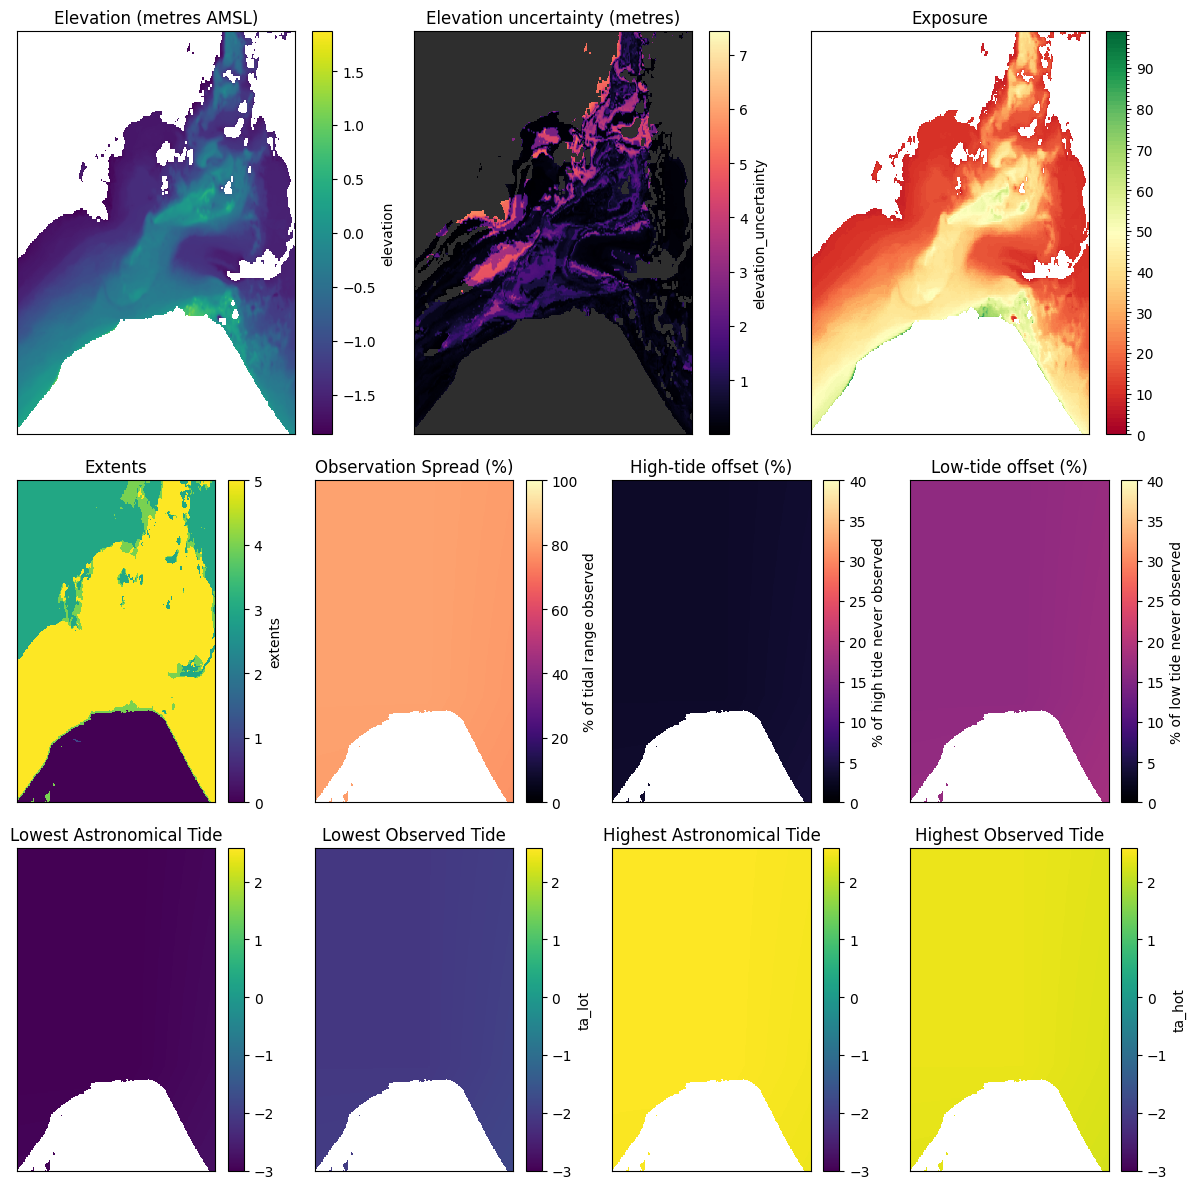

In [18]:
fig = plt.figure(figsize=(12, 12), tight_layout=True)
ax_dict = fig.subplot_mosaic(
    """
    AAAABBBBCCCC
    DDDEEEFFFGGG
    HHHIIIJJJKKK
    """,
    height_ratios=[1, 0.8, 0.8],
)

# label_params = dict(add_labels=False, yticks=[], xticks=[])

# Plot Elevation with hillshade
ds["elevation"].plot.imshow(
    ax=ax_dict["A"],
    cmap="viridis",
    interpolation="bilinear",
)
intertidal_hillshade(ds["elevation"], ds["extents"], vert_exag=300).plot.imshow(
    ax=ax_dict["A"],
    interpolation="bilinear",
)
ax_dict["A"].set_title("Elevation (metres AMSL)")

# Plot uncertainty
ds["elevation_uncertainty"].plot.imshow(
    ax=ax_dict["B"],
    cmap="magma",
    interpolation="bilinear",
)
ax_dict["B"].set_title("Elevation uncertainty (metres)")
ax_dict["B"].set_facecolor("#2E2E2E")

# Plot Exposure
ds["exposure"].plot.imshow(
    ax=ax_dict["C"],
    cmap="RdYlGn",
    levels=np.arange(0, 100, 1),
    add_labels=False,
    yticks=[],
)
ax_dict["C"].set_title("Exposure")

# Plot Extents
ds["extents"].astype(np.int16).plot.imshow(ax=ax_dict["D"])
ax_dict["D"].set_title("Extents")

# Plot the observation spread
ds["ta_spread"].plot.imshow(
    ax=ax_dict["E"],
    vmin=0,
    vmax=100,
    cmap="magma",
    cbar_kwargs={"label": "% of tidal range observed"},
)
ax_dict["E"].set_title("Observation Spread (%)")

# Plot the high-tide offset
ds["ta_offset_high"].plot.imshow(
    ax=ax_dict["F"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of high tide never observed"},
)
ax_dict["F"].set_title("High-tide offset (%)")

# Plot the low-tide offset
ds["ta_offset_low"].plot.imshow(
    ax=ax_dict["G"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of low tide never observed"},
)
ax_dict["G"].set_title("Low-tide offset (%)")

# Plot the LAT
ds["ta_lat"].plot.imshow(
    ax=ax_dict["H"],
    vmin=ds["ta_lat"].min(),
    vmax=ds["ta_hat"].max(),
    add_labels=False,
)
ax_dict["H"].set_title("Lowest Astronomical Tide")

# Plot the LOT
ds["ta_lot"].plot.imshow(
    ax=ax_dict["I"], vmin=ds["ta_lat"].min(), vmax=ds["ta_hat"].max()
)
ax_dict["I"].set_title("Lowest Observed Tide")

# Plot the HAT
ds["ta_hat"].plot.imshow(
    ax=ax_dict["J"],
    vmin=ds["ta_lat"].min(),
    vmax=ds["ta_hat"].max(),
    add_labels=False,
    yticks=[],
)
ax_dict["J"].set_title("Highest Astronomical Tide")

# Plot the HOT
ds["ta_hot"].plot.imshow(
    ax=ax_dict["K"],
    vmin=ds["ta_lat"].min(),
    vmax=ds["ta_hat"].max(),
)
ax_dict["K"].set_title("Highest Observed Tide")

# Remove axis labels
for label, ax in ax_dict.items():
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")

## Export layers

In [114]:
# Create output folder. If it doesn't exist, create it
output_dir = f"data/interim/{study_area}/{start_date}-{end_date}"
os.makedirs(output_dir, exist_ok=True)

# Prepare data for export
ds["qa_ndwi_freq"] *= 100  # Convert frequency to %

# Prepare for export by correctly setting nodata and dtypes, then
# export to file
ds_prepared = prepare_for_export(ds, output_location=output_dir)

In [16]:
# Export figure
fig.savefig(f"data/interim/{study_area}/{start_date}-{end_date}/outputs.png")

### Close Dask client

In [ ]:
client.close()